## CSCI.635.03 Project Code
This project focuses on creating a recipe generator that takes input in two forms: a list of ingredients or an image of a dish. Using state-of-the-art models like GPT-2 for recipe generation, CLIP for image-to-text matching, and Sentence-BERT for semantic similarity, the system bridges the gap between images and recipes. The demonstrates the powerful integration of natural language processing (NLP) and computer vision.

# Install required libraries

In [1]:
!pip install transformers datasets tqdm torch torchvision sentence-transformers Pillow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Import libraries

In [2]:
import time
import pandas as pd
import torch
from PIL import Image
from tqdm.auto import tqdm
from datasets import Dataset
from sentence_transformers import SentenceTransformer, util
from transformers import (
    GPT2TokenizerFast,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    pipeline,
    CLIPProcessor,
    CLIPModel,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# Load Dataset

In [3]:
from google.colab import files

uploaded = files.upload()
csv_filename = list(uploaded.keys())[0]
df = pd.read_csv(csv_filename)
print(df.columns)
print(df.head())

Saving Cleaned_Indian_Food_Dataset.csv to Cleaned_Indian_Food_Dataset.csv
Index(['TranslatedRecipeName', 'TranslatedIngredients', 'TotalTimeInMins',
       'Cuisine', 'TranslatedInstructions', 'URL', 'Cleaned-Ingredients',
       'image-url', 'Ingredient-count'],
      dtype='object')
                                TranslatedRecipeName  \
0                               Masala Karela Recipe   
1                         Spicy Tomato Rice (Recipe)   
2  Ragi Semiya Upma Recipe - Ragi Millet Vermicel...   
3  Gongura Chicken Curry Recipe - Andhra Style Go...   
4  Andhra Style Alam Pachadi Recipe - Adrak Chutn...   

                               TranslatedIngredients  TotalTimeInMins  \
0  1 tablespoon Red Chilli powder,3 tablespoon Gr...               45   
1   2 teaspoon cashew - or peanuts, 1/2 Teaspoon ...               15   
2  1 Onion - sliced,1 teaspoon White Urad Dal (Sp...               50   
3  1/2 teaspoon Turmeric powder (Haldi),1 tablesp...               45   
4   oil - as

# Preprocess the dataset to create text input-output pairs

In [4]:
def preprocess_dataset(dataframe):
    return dataframe.apply(
        lambda x: f"<|startoftext|>Ingredients:\n{x['TranslatedIngredients'].strip()}\n\nInstructions:\n{x['TranslatedInstructions'].strip()}<|endoftext|>",
        axis=1,
    ).to_list()

data = preprocess_dataset(df)
print(f"Loaded and preprocessed dataset with {len(data)} samples!")

Loaded and preprocessed dataset with 5938 samples!


# Splitting dataset and Convert to Hugging Face Dataset objects

In [5]:
train_size = 0.85
train_len = int(train_size * len(data))
train_data = data[:train_len]
val_data = data[train_len:]

def prepare_dataset(data):
    return Dataset.from_dict({"text": data})

train_ds = prepare_dataset(train_data)
val_ds = prepare_dataset(val_data)

print(f"Training samples: {len(train_ds)}, Validation samples: {len(val_ds)}")

Training samples: 5047, Validation samples: 891


# Initialize the tokenizer and model

In [6]:
model_name = "gpt2"
tokenizer = GPT2TokenizerFast.from_pretrained(
    model_name,
    bos_token="<|startoftext|>",
    eos_token="<|endoftext|>",
    unk_token="<|unknown|>",
    pad_token="<|pad|>",
)

model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
model.resize_token_embeddings(len(tokenizer))

print("Tokenizer and Model Ready!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Tokenizer and Model Ready!


# Tokenization function and Removal of unnecessary columns to avoid Trainer warnings

In [7]:
def tokenize_function(examples):
    encodings = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512,
    )
    encodings["labels"] = encodings["input_ids"]
    return encodings

train_ds = train_ds.map(tokenize_function, batched=True)
val_ds = val_ds.map(tokenize_function, batched=True)
train_ds = train_ds.remove_columns(["text"])
val_ds = val_ds.remove_columns(["text"])

print("Data Tokenized and Ready for Training!")

Map:   0%|          | 0/5047 [00:00<?, ? examples/s]

Map:   0%|          | 0/891 [00:00<?, ? examples/s]

Data Tokenized and Ready for Training!


# Define training arguments

In [8]:
from transformers import TrainingArguments
import torchvision
torchvision.disable_beta_transforms_warning()
training_args = TrainingArguments(
    output_dir="./model_output",
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps=50,
    save_strategy="epoch",
    save_total_limit=2,
    num_train_epochs=6,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    report_to="none",
)


print("Training Arguments Ready!")

Training Arguments Ready!


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Train the model

In [9]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
)

print("Starting training...")
trainer.train()
trainer.save_model("./khaanaGPT")
tokenizer.save_pretrained("./khaanaGPT")
print("Model and Tokenizer Saved!")

<ipython-input-9-51846e8f605c>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Step,Training Loss,Validation Loss
100,3.331100,2.276154
200,1.716200,1.552854
300,1.542300,1.482195
400,1.521500,1.445520
500,1.473900,1.417500
600,1.511700,1.400737
700,1.472400,1.380642
800,1.504900,1.367769
900,1.411700,1.355581
1000,1.457500,1.346091


Model and Tokenizer Saved!


## PLOT

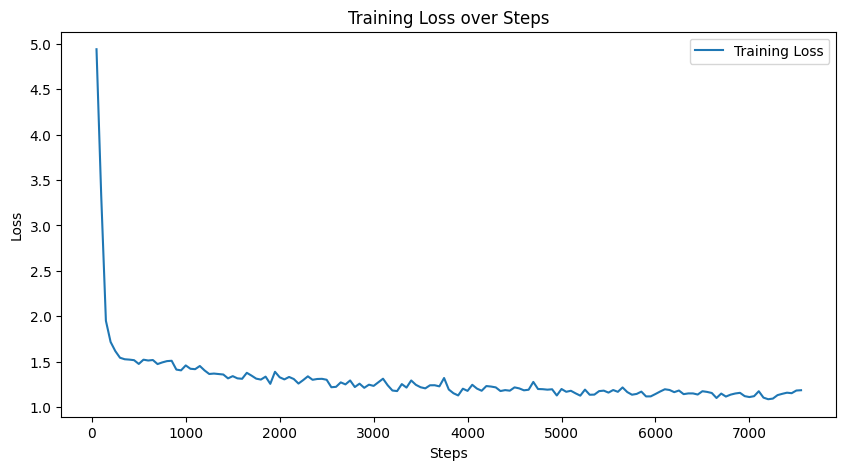

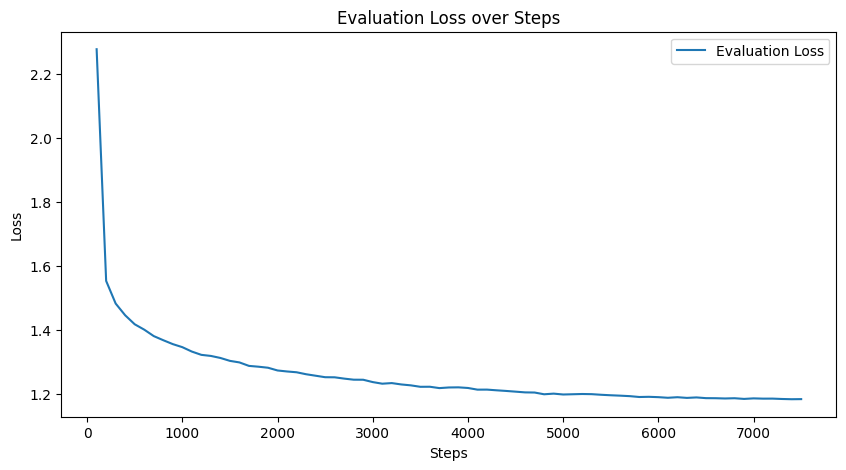

In [13]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

metrics_df = pd.DataFrame(log_history)

# Filter the DataFrame for specific metrics
train_loss = metrics_df[metrics_df['step'].notnull() & metrics_df['loss'].notnull()]
eval_loss = metrics_df[metrics_df['eval_loss'].notnull()]

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss['step'], train_loss['loss'], label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss over Steps')
plt.legend()
plt.show()

# Plot evaluation loss
plt.figure(figsize=(10, 5))
plt.plot(eval_loss['step'], eval_loss['eval_loss'], label='Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Evaluation Loss over Steps')
plt.legend()
plt.show()

# Calculate perplexity from evaluation loss

In [11]:
from math import exp
from transformers import Trainer, TrainingArguments

trained_model = GPT2LMHeadModel.from_pretrained("./khaanaGPT").to(device)
trained_tokenizer = GPT2TokenizerFast.from_pretrained("./khaanaGPT")

evaluation_args = TrainingArguments(
    output_dir="./evaluation_output",
    per_device_eval_batch_size=4,
    report_to="none",
    disable_tqdm=False,
)

evaluation_trainer = Trainer(
    model=trained_model,
    args=evaluation_args,
    eval_dataset=val_ds,
    tokenizer=trained_tokenizer,
)

print("Evaluating the trained model...")
metrics = evaluation_trainer.evaluate()

eval_loss = metrics.get("eval_loss")
perplexity = exp(eval_loss) if eval_loss is not None else None

print("\nEvaluation Results:")
print(f"Validation Loss: {eval_loss:.4f}" if eval_loss else "Validation Loss: N/A")
if perplexity:
    print(f"Validation Perplexity: {perplexity:.2f}")
else:
    print("Perplexity could not be calculated.")

Evaluating the trained model...


<ipython-input-11-26b583b4cbf5>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  evaluation_trainer = Trainer(



Evaluation Results:
Validation Loss: 1.1836
Validation Perplexity: 3.27


# Test with example ingredients

In [15]:
!pip install fuzzywuzzy[speedup] --quiet
from transformers import pipeline
import nltk
from nltk.corpus import wordnet as wn
from fuzzywuzzy import fuzz
import time

# Initialize the GPT-2 recipe generator
recipe_generator = pipeline(
    task="text-generation",
    model="./khaanaGPT",
    tokenizer="./khaanaGPT",
    device=0 if torch.cuda.is_available() else -1,
)

# Download the WordNet corpus for synonym expansion
nltk.download('wordnet')

def expand_with_synonyms(ingredients_list):
    """
    Expand the ingredients list with synonyms using WordNet.
    """
    expanded_ingredients = set()
    for ingredient in ingredients_list:
        expanded_ingredients.add(ingredient.lower())
        for syn in wn.synsets(ingredient):
            for lemma in syn.lemmas():
                expanded_ingredients.add(lemma.name().lower())
    return list(expanded_ingredients)

def create_prompt(ingredients, recipe_name):
    """
    Create a prompt that includes both the recipe name and the ingredients.
    """
    ingredients_text = ", ".join(ingredients.split(","))
    return f"<|startoftext|>Recipe Name: {recipe_name}\nIngredients:\n{ingredients_text}\nInstructions:\n"

def generate_recipe_with_synonyms(user_ingredients, df, threshold=50):
    """
    Generate a recipe considering user ingredients and their synonyms.
    """
    user_ingredients_list = user_ingredients.split(", ")

    # Expand user ingredients with synonyms
    expanded_ingredients = expand_with_synonyms(user_ingredients_list)

    # Initialize variables to store the best match
    best_match_score = 0
    best_match_row = None

    # Iterate through the dataset to find the best match using expanded ingredients
    for _, row in df.iterrows():
        dataset_ingredients = row["Cleaned-Ingredients"].split(", ")

        # Compute match scores for expanded ingredients
        match_scores = [fuzz.partial_ratio(expanded_ingredient, dataset_ingredient)
                        for expanded_ingredient in expanded_ingredients
                        for dataset_ingredient in dataset_ingredients]

        average_match_score = sum(match_scores) / len(match_scores) if match_scores else 0

        if average_match_score > best_match_score and average_match_score >= threshold:
            best_match_score = average_match_score
            best_match_row = row

    # Generate recipe if a match is found
    if best_match_row is not None:
        dataset_ingredients_set = set(best_match_row["Cleaned-Ingredients"].split(", "))
        user_ingredients_set = set(user_ingredients_list)
        additional_ingredients = dataset_ingredients_set - user_ingredients_set

        suggested_recipe_name = best_match_row['TranslatedRecipeName']
        print(f"Based on the ingredients you provided, you can try making: {suggested_recipe_name}")
        if additional_ingredients:
            print(f"Suggested additional ingredients: {', '.join(additional_ingredients)}")

        # Combine user and additional ingredients for recipe generation
        combined_ingredients = ", ".join(user_ingredients_set | additional_ingredients)
        prompt = create_prompt(combined_ingredients, suggested_recipe_name)

        # Generate the recipe
        start_time = time.time()
        result = recipe_generator(prompt, max_new_tokens=150, pad_token_id=50259)[0]["generated_text"]
        inference_time = time.time() - start_time
        print(f"\nGenerated Recipe:\n{result}")
        print(f"Inference Time: {inference_time:.2f} seconds")
    else:
        print("No suitable recipe found for the provided ingredients.")
        print("Please try adding more ingredients or checking similar recipes from the dataset.")

# Example usage
user_ingredients = "chicken, tomato, garlic, cilantro"

generate_recipe_with_synonyms(user_ingredients, df)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Based on the ingredients you provided, you can try making: Milagai Bajji Stuffed with Masala Chicken Recipe
Suggested additional ingredients: tomato,salt,chicken breasts,ginger,coconut,fennel seeds (saunf),ajwain (carom seeds),cloves garlic,black peppercorns,coriander (dhania) seeds,onion,cumin seeds (jeera),dry red chillies,badi hari mirch (large green chilli),sunflower oil

Generated Recipe:
<|startoftext|>Recipe Name: Milagai Bajji Stuffed with Masala Chicken Recipe
Ingredients:
chicken,  cilantro,  tomato,  tomato, salt, chicken breasts, ginger, coconut, fennel seeds (saunf), ajwain (carom seeds), cloves garlic, black peppercorns, coriander (dhania) seeds, onion, cumin seeds (jeera), dry red chillies, badi hari mirch (large green chilli), sunflower oil,  garlic
Instructions:
To make the milagai bajji stuffed with masala chicken, first wash and clean the chicken well.
(Don't make the masala chicken hard and keep it aside)Heat oil in a heavy bottomed pan.
Add mustard seeds, cumin see

# Viability testing

In [ ]:
viability_training_args = TrainingArguments(
    output_dir="./viability_test_model",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,  # Only train for 1 epoch
    save_strategy="no",
    evaluation_strategy="epoch",
    logging_steps=10,
    report_to="none",
    disable_tqdm=False,
    do_train=True,
    do_eval=True,
    learning_rate=5e-5,
    gradient_accumulation_steps=1,
)

viability_trainer = Trainer(
    model=model,
    args=viability_training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
)

print("Starting viability test...")

start_time = time.time()
viability_trainer.train()
training_time = time.time() - start_time

start_time = time.time()
metrics = viability_trainer.evaluate()
evaluation_time = time.time() - start_time

print(f"\nViability Test Results:")
print(f"Training Time: {training_time:.2f} seconds for {len(train_ds)} training samples")
print(f"Evaluation Time: {evaluation_time:.2f} seconds for {len(val_ds)} validation samples")
print("Evaluation Metrics:", metrics)

Starting viability test...


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-6c5a2f2f24b2>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  viability_trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.127900,1.170897



Viability Test Results:
Training Time: 417.83 seconds for 5047 training samples
Evaluation Time: 18.33 seconds for 891 validation samples
Evaluation Metrics: {'eval_loss': 1.1708968877792358, 'eval_runtime': 18.3246, 'eval_samples_per_second': 48.623, 'eval_steps_per_second': 24.339, 'epoch': 1.0}


## Image to Recipe

In [ ]:
# from google.colab import files
# uploaded = files.upload()
df = pd.read_csv('Cleaned_Indian_Food_Dataset.csv')

# Extract the list of possible dish names directly from the dataset
dishes = df['TranslatedRecipeName'].tolist()

# Load the CLIP model and processor from HuggingFace
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load Sentence-BERT model for semantic similarity
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)

In [ ]:
# Function to predict the dish name based on the input image
def predict_dish_from_image(image_path):
    image = Image.open(image_path)
    inputs = processor(text=dishes, images=image, return_tensors="pt", padding=True).to(device)  # Move inputs to GPU

    # Get predictions from CLIP
    with torch.no_grad():
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image  # similarity between image and text
        probs = logits_per_image.softmax(dim=1)  # softmax to get probabilities
    predicted_dish = dishes[torch.argmax(probs)]
    return predicted_dish

# Function to calculate semantic similarity
def get_most_similar_dish(predicted_dish):
    dish_embeddings = sbert_model.encode(dishes, convert_to_tensor=True, device=device)
    predicted_dish_embedding = sbert_model.encode([predicted_dish], convert_to_tensor=True, device=device)
    similarities = util.pytorch_cos_sim(predicted_dish_embedding, dish_embeddings)[0]
    most_similar_idx = torch.argmax(similarities)
    most_similar_dish = dishes[most_similar_idx]

    return most_similar_dish

def get_ingredients_for_dish(dish_name):
    ingredients = df[df['TranslatedRecipeName'] == dish_name]['Cleaned-Ingredients'].values
    if len(ingredients) > 0:
        return ingredients[0]
    else:
        return "Ingredients not found for this dish."

In [ ]:
# Load the khaanGPT model (Phase-1)
recipe_generator = pipeline(
    task="text-generation",
    model="./khaanaGPT",
    tokenizer="./khaanaGPT",
    device=0 if torch.cuda.is_available() else -1,
)

# Function to retrieve translated instructions for a given dish
def get_translated_instructions(dish_name):
    instructions = df[df['TranslatedRecipeName'] == dish_name]['TranslatedInstructions'].values
    if len(instructions) > 0:
        return instructions[0]
    else:
        return "Recipe instructions not found for this dish."

image_path = "Black_Bean_Burrito.jpg"

# Step 1: Predict the dish from the image
predicted_dish = predict_dish_from_image(image_path)
print(f"Predicted Dish: {predicted_dish}")

# Step 2: Retrieve the most similar dish from the dataset using SBERT
most_similar_dish = get_most_similar_dish(predicted_dish)
print(f"Most Similar Dish in Dataset: {most_similar_dish}")

# Step 3: Retrieve the ingredients for the most similar dish
ingredients = get_ingredients_for_dish(most_similar_dish)
print(f"Ingredients for {most_similar_dish}: {ingredients}")

# Step 4: Retrieve the recipe instructions for the most similar dish
translated_instructions = get_translated_instructions(most_similar_dish)
print(f"Recipe Instructions for {most_similar_dish}:\n{translated_instructions}")


Predicted Dish: Healthy Black Bean Stuffed Burrito Recipe With Amaranth And Quinoa
Most Similar Dish in Dataset: Healthy Black Bean Stuffed Burrito Recipe With Amaranth And Quinoa
Ingredients for Healthy Black Bean Stuffed Burrito Recipe With Amaranth And Quinoa: salt,canned black beans,red bell pepper (capsicum),mango pickle sauce,sour,coriander (dhania) leaves,cloves garlic,virgin olive oil,water,mozzarella cheese cheese,lemon,sweet corn,mixed grains (amaranth,tortillas
Recipe Instructions for Healthy Black Bean Stuffed Burrito Recipe With Amaranth And Quinoa:
To begin making the Healthy Black Bean Stuffed Burrito With Amaranth And Quinoa, first cook the grains.
To do that, place a sauce pan with 1-1/2 cups of water on the heat and bring it to a boil along with required salt.
Once its at a rolling boil, stir in the mixed grains.
Turn the heat down to low, cover the saucepan and allow it to cook/simmer for for about 15 minutes or until grains are cooked and the water is absorbed compl